In [13]:
import src
from pathlib import Path
import pandas as pd
import yaml
import numpy as np
import scipy
import matplotlib.pyplot as plt
import lifelines
import scipy.stats
import scipy.special
import scipy.integrate

base_dir = Path(src.__file__).parent.parent
data_dir = base_dir/"data"
restults_directory = base_dir/"results"/"scratch"

In [14]:
biasi_analysis = pd.read_csv(data_dir / "biasi.csv")
raw_oskin_meta_data = yaml.safe_load(open(data_dir / "metadata.yaml"))
oskin_meta_data = pd.DataFrame(raw_oskin_meta_data).T

In [15]:
biasi_analysis["Site*"]

0             Coachella
1        Thousand Palms
2           Burro Flats
3         Pitman Canyon
4              Hog Lake
5           Mystic Lake
6            Wrightwood
7         Pallett Creek
8      Frazier Mountain
9          Bidart Ranch
10           Santa Cruz
11              Vedanta
12          Noyo Canyon
13         Tyson Lagoon
14           Mira Vista
15    Elsinore Glen Ivy
16      Garlock Central
17         Garlock West
18              Compton
Name: Site*, dtype: object

In [16]:
oskin_meta_data.head()

,name,fault,latitude,longitude,start_time,end_time,gaps,historic_events,notes,references
DSF_Qatar.txt,Quatar,Dead Sea Fault,29.812889,35.073972,-3000,2025,None,"[363, 749, 1068, 1212, 1458]","Historic events in 363, 749, 1068, 1212, and 1...","[Klinger, Y., Le Béon, M. & Al-Qaryouti, M. 50..."
CSZ_central.txt,Central Cascadia Subduction Zone,Central Cascadia Subduction Zone,44.566667,-125.15,None,None,None,[1700],Events present in central part of subduction z...,"[Goldfinger, C. et al. Turbidite Event History..."
SAF_Pallett_Creek.txt,Pallett Creek,San Andreas Fault,34.458333,-117.893611,700,2025,None,"[1812, 1857]",Historic events in 1812 and 1857 A.D.,"[Scharer, K. M., Biasi, G. P. & Weldon II, R. ..."
DSF_Beteiha.txt,Beteiha,Dead Sea Fault,32.87,35.65,None,2025,None,"[-142, 130, 303, 348, 363, 500, 660, 1202, 1758]","Event chronology from Ref 49, with historic ev...","[Wechsler, N. et al. A Paleoseismic Record of ..."
SAF_Wrightwood.txt,Wrightwood,San Andreas Fault,34.369444,-117.667778,-3000,2025,"[[-1500, 500]]","[1812, 1857]",Historic events in 1812 and 1857 A.D. Old and ...,"[Scharer, K. M., Weldon, R. J., Fumal, T. E. &..."


In [17]:
shared_sites = np.intersect1d(biasi_analysis["Site*"].values, oskin_meta_data["name"].values)
shared_sites

array(['Hog Lake', 'Mystic Lake', 'Noyo Canyon', 'Pallett Creek',
       'Wrightwood'], dtype=object)

In [18]:
def get_weibull_params(site_name, number_of_samples=10):
    filename = oskin_meta_data[oskin_meta_data["name"] == site_name].index.values[0]
    data = src.paleoseismic.PaleoseismicCatalog(
        data_dir
        / "trench_records"
        / filename,
        **raw_oskin_meta_data[filename],
    )

    dt = []
    event_observed = []
    entry_time = []
    for _ in range(number_of_samples):
        sample = data.sample()
        i_dt, i_event_observed, i_entry_time = src.paleoseismic.get_dt(sample, data)
        dt.append(i_dt)
        event_observed.append(i_event_observed)
        entry_time.append(i_entry_time)

    dt = np.concatenate(dt)
    event_observed = np.concatenate(event_observed)
    entry_time = np.concatenate(entry_time)

    wb = lifelines.WeibullFitter().fit(dt, event_observed=event_observed, entry=entry_time)

    return wb.params_.loc["rho_"], wb.params_.loc["lambda_"]


def get_lognormal_params(site_name):
    mu = np.log(
        biasi_analysis.loc[biasi_analysis["Site*"] == site_name, "LN: Exp(⁠⁠) (Yr)"]
    )
    sigma = biasi_analysis.loc[biasi_analysis["Site*"] == site_name, "LN"]
    return mu, sigma


def get_exponential_params(site_name):
    lam = (
        1.0
        / biasi_analysis.loc[biasi_analysis["Site*"] == site_name, "EXP:\xa0\xa0(Yr)"]
    )
    return lam


# --------------------------------
# Conditional (fixed-observer) S(t)/S(t0)
# --------------------------------


def conditional_weibull_hiatus_p(k, lam, t, t0):
    S = 1 - scipy.stats.weibull_min.cdf(t, c=k, scale=lam)
    S0 = 1 - scipy.stats.weibull_min.cdf(t0, c=k, scale=lam)
    return S / S0


def conditional_lognormal_hiatus_p(mu, sigma, t, t0):
    S = 1 - scipy.stats.lognorm.cdf(t, s=sigma, scale=np.exp(mu))
    S0 = 1 - scipy.stats.lognorm.cdf(t0, s=sigma, scale=np.exp(mu))
    return S / S0


def conditional_exponential_hiatus_p(lam, t, t0):
    return np.exp(-lam * (t - t0))


# --------------------------------
# Random-observer (length-biased) P(A+R > t)
# --------------------------------


def single_site_weibull_hiatus_p_random_obs(k, lam, t):
    """S_L(t) for Weibull(k, lam) under random-observer (length-biased) sampling."""
    x = (t / lam) ** k
    return scipy.special.gammaincc(1 + 1.0 / k, x)


def single_site_lognormal_hiatus_p_random_obs(mu, sigma, t):
    # S_L(t) = [ t S(t) + ∫_t^∞ S(u) du ] / E[T],  S(u)=1-F(u),  E[T]=exp(mu+0.5*sigma^2)
    def S(u):
        return 1.0 - scipy.stats.lognorm.cdf(u, s=sigma, scale=np.exp(mu))

    ET = np.exp(mu + 0.5 * sigma**2)
    tail_int, _ = scipy.integrate.quad(lambda u: S(u), t, np.inf, limit=200)
    return (t * S(t) + tail_int) / ET


def single_site_exponential_hiatus_p_random_obs(lam, t):
    # S_L(t) = (1 + lam * t) * exp(-lam * t)
    return (1.0 + lam * t) * np.exp(-lam * t)


# -----------------------------
# Dispatcher
# -----------------------------


def get_model_params(model, site):
    if model == "weibull":
        return get_weibull_params(site)
    elif model == "lognormal":
        return get_lognormal_params(site)
    elif model == "exponential":
        return get_exponential_params(site)
    else:
        raise ValueError(f"Unknown model: {model}")


def hiatus_p(model, site, dt, t0=None, random_obs=False):
    """
    model: 'weibull' | 'lognormal' | 'exponential'
    site: site name string
    t: total time (years) for the hiatus threshold
    t0: optional censoring/conditioning time (years since last event at start of hiatus).
        If None, pulled from biasi_analysis['Open Interval'] for the site.
    random_obs: if True, computes length-biased P(A+R>t); else conditional S(t)/S(t0)
    """
    if t0 is None:
        # ensure scalar
        t0 = biasi_analysis.loc[
            biasi_analysis["Site*"] == site, "Open Interval"
        ].values[0]

    params = get_model_params(model, site)

    if random_obs:
        if model == "weibull":
            return single_site_weibull_hiatus_p_random_obs(*params, dt)
        elif model == "lognormal":
            return single_site_lognormal_hiatus_p_random_obs(*params, dt)
        elif model == "exponential":
            return single_site_exponential_hiatus_p_random_obs(
                params, dt
            )  # params is lam
    else:
        if model == "weibull":
            return conditional_weibull_hiatus_p(*params, t0 + dt, t0)
        elif model == "lognormal":
            return conditional_lognormal_hiatus_p(*params, t0 + dt, t0)
        elif model == "exponential":
            return conditional_exponential_hiatus_p(params, t0 + dt, t0)  # params is la

    raise ValueError(f"Unhandled case for model={model}")


# --------------------------------
# Aggregation across sites
# --------------------------------


def conditional_aggregate_hiatus_p(model, sites, dt):
    p = []
    for s in sites:
        t = biasi_analysis.loc[biasi_analysis["Site*"] == s, "Open Interval"]
        p.append(hiatus_p(model, s, dt, t0=t - dt, random_obs=False))
    return np.prod(p)


def random_obs_aggregate_hiatus_p(
    model, sites, t, sample_duration=100000.0, number_of_sample_queries=100000
):
    """
    Monte Carlo: merge independent renewal timelines across sites, then
    sample random times and check if containing interval length > t.
    """
    rng = np.random.default_rng()
    timelines = []

    for site in sites:
        params = get_model_params(model, site)

        total_time = 0.0
        dt_list = []

        while total_time < sample_duration:
            if model == "weibull":
                k, lam = params
                r = scipy.stats.weibull_min(c=k, scale=lam).rvs(random_state=rng)
            elif model == "lognormal":
                mu, sigma = params
                r = scipy.stats.lognorm(s=sigma, scale=np.exp(mu)).rvs(random_state=rng)
            elif model == "exponential":
                lam = params
                r = scipy.stats.expon(scale=1.0 / lam).rvs(random_state=rng)
            else:
                raise ValueError(f"Unknown model: {model}")

            dt_list.append(r)
            total_time += r

        timelines.append(np.cumsum(dt_list))

    combined = np.sort(np.concatenate(timelines))

    qs = rng.random(number_of_sample_queries) * sample_duration
    interval_lengths = np.array(
        [src.stats_utils.get_full_interval(combined, q) for q in qs]
    )

    return np.mean(interval_lengths > t)

In [19]:
def plot_linedot(x1, x2, y, c, ax):
    ax.plot([x1, x2],[y, y], c=c)
    ax.scatter(x2, y, c=c, s=20)

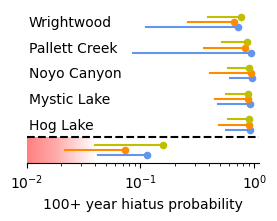

In [23]:
model_color_key = dict(
    weibull = "cornflowerblue",
    exponential = "y",
    lognormal ="darkorange",
)

fig, ax = plt.subplots(figsize=(3,2))

t_hiatus = 100

models = ["weibull", "lognormal", "exponential"]
results = {}

for i, site in enumerate(shared_sites):
    results[site] = {}
    for j, model in enumerate(models):
        results[site][model] = {}
        results[site][model]["params"] = get_model_params(model, site)
        p1 = hiatus_p(model, site, t_hiatus, random_obs=False)
        p2 = hiatus_p(model, site, t_hiatus, random_obs=True)
        results[site][model]["continuous"] = p1
        results[site][model]["random"] = p2
        plot_linedot(p1, p2, i + 1 - 1/5 + j/5, c=model_color_key[model], ax=ax)

for i, model in enumerate(models):
    p1 = conditional_aggregate_hiatus_p(model, shared_sites, t_hiatus)
    p2 = random_obs_aggregate_hiatus_p(model, shared_sites, t_hiatus)
    plot_linedot(p1, p2, -1/5 + i/5, c=model_color_key[model], ax=ax)

ax.axhline(0.5, c="k", ls="--")
[ax.axhspan(-0.5, 0.5, 0, 0.3*i/50, facecolor="r", edgecolor="none", alpha=0.01) for i in range(50)]

for i, site in enumerate(shared_sites, start=1):
    ax.text(0.01, i, site, va='center', ha='left', fontsize=10, transform=ax.get_yaxis_transform())

ax.set(
    xlabel=f"{t_hiatus}+ year hiatus probability",
    ylim=(-0.5, len(shared_sites)+0.5),
    xlim=(1e-2, 1.1),
    yticks=[],
    yticklabels=[],
    xscale="log",
)

# remove the left top and right spines
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(restults_directory/"biasi_aggregate_comparison.pdf", dpi=300)

In [21]:
for site in shared_sites:
    print(f"{site}: {results[site]["weibull"]["params"]}")

Hog Lake: (np.float64(1.5812239780452417), np.float64(217.3086863438664))
Mystic Lake: (np.float64(1.4394943183901716), np.float64(218.24021967245884))
Noyo Canyon: (np.float64(1.7744976183577814), np.float64(253.1179930731804))
Pallett Creek: (np.float64(2.8374362599754144), np.float64(180.27407327370992))
Wrightwood: (np.float64(1.8708192367664842), np.float64(123.92316433777259))


In [22]:
results["Wrightwood"]["weibull"]["random"]

np.float64(0.7298584548128417)